In [1]:
import os
import sys
import time
import sklearn
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-rc0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),   
])

for _ in range(20):
    """
    model.add(keras.layers.Dense(100,activation="relu"))
    model.add(keras.layers.BatchNormalization())
    """
    # selu 优于 上述方法
    model.add(keras.layers.Dense(100,activation="selu")) # selu 自带归一化
    
# 一般再最后几层做dropout    
# AlphaDropout 1. 均值方差不变，2. 归一化性质不变
model.add(keras.layers.AlphaDropout(rate=0.5))

model.add(keras.layers.Dense(10,activation="softmax"))

model.compile(loss = "sparse_categorical_crossentropy", # 损失函数
              optimizer = "adam",                       # 模型的求解方法
              metrics = ["accuracy"])                   # 增加 accuracy 指标

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# 查询模型概况
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [8]:

logdir = os.path.join("dnn_selu_dropout_callbacks")

if not os.path.exists(logdir):
    os.mkdir(logdir)
    
output_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True), # 保存最好的模型，默认最新
    keras.callbacks.EarlyStopping(
        min_delta= 1e-3, 
        patience=5, 
    ),
]


history = model.fit(x_train_scaled,y_train,epochs=100,
          validation_data=(x_valid_scaled,y_valid),
          callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 17s 311us/sample - loss: 0.8467 - accuracy: 0.7152 - val_loss: 1.1034 - val_accuracy: 0.7752
Epoch 2/100
55000/55000 [==============================] - 14s 260us/sample - loss: 0.6738 - accuracy: 0.7709 - val_loss: 0.7171 - val_accuracy: 0.8156
Epoch 3/100
55000/55000 [==============================] - 14s 260us/sample - loss: 0.6250 - accuracy: 0.7869 - val_loss: 0.7062 - val_accuracy: 0.8104
Epoch 4/100
55000/55000 [==============================] - 15s 265us/sample - loss: 0.6029 - accuracy: 0.7946 - val_loss: 0.8587 - val_accuracy: 0.7716
Epoch 5/100
55000/55000 [==============================] - 14s 259us/sample - loss: 0.5681 - accuracy: 0.8093 - val_loss: 0.7791 - val_accuracy: 0.8292
Epoch 6/100
55000/55000 [==============================] - 15s 267us/sample - loss: 0.6416 - accuracy: 0.7705 - val_loss: 0.6947 - val_accuracy: 0.8314
Epoch 7/100
55000/55000 [==============

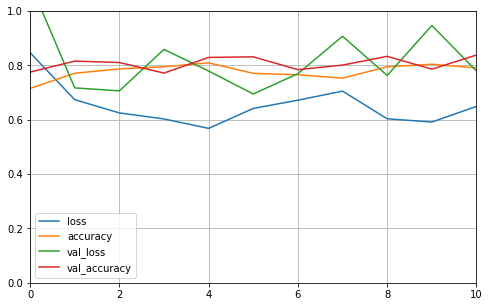

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8712444447994232, 0.8208]

In [ ]:
# 打开tensorflow Tensorboard 
!tensorboard --logdir=callbacks

In [ ]:
# http://localhost:6006/